In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

#bo.cloud.set_verbosity('QUIET')
plt.style.use(qv.get_qctrl_style())

controls_for_plots = lambda opt: {
    '$\\Delta$': opt['output']['delta'],
    '$\\Omega$': opt['output']['omega'],
    '$\\Phi$': opt['output']['phi']
}

Boulder Opal client update available.
Latest version is 1.4.0, you have 1.3.2.
Visit https://docs.q-ctrl.com/boulder-opal/changelog for the latest product updates.


In [3]:
# Set parameters.
omega_max = 5 * 2 * np.pi * 1e6 # rad/s
delta_max = omega_max
tau = 1 * 1e-6 # s

# Define the control.
segment_countz = [128,128,128] #drive, detune, rabi
sample_times = np.linspace(0, tau, 200)

# Define basis.
basis_labels = ["0", "01", "0r", "1-10", "1-r0z", "111", "r11z", "r1r", "1r1"]

# Components for the drive operator.
drive_operator = np.zeros((9, 9))
drive_operator[([1, 2], [2, 1])] = 1
drive_operator[([3, 4], [4, 3])] = np.sqrt(2)
drive_operator[([5, 6], [6, 5])] = np.sqrt(2)
drive_operator[([6, 7], [7, 6])] = np.sqrt(2)
drive_operator[([5, 8], [8, 5])] = 1

# Components for the detuning operator.
detuning_operator = np.diag([0, 0, -1, 0, -1, 0, -1, -2, -1])

# Components for the CZ operator.
cz_0 = np.diag([1, 0, 0, 0, 0, 0, 0, 0, 0])
cz_1 = np.diag([0, 1, 0, 0, 0, 0, 0, 0, 0])
cz_11 = np.diag([0, 0, 0, 1, 0, 0, 0, 0, 0])
cz_111 = np.diag([0, 0, 0, 0, 0, 1, 0, 0, 0])

In [10]:
graph = bo.Graph()
# Real piece-wise constant signal representing the Rabi amplitude.
uomega = (
    graph.real_optimizable_pwc_signal(
        segment_count = segment_countz[0], 
        duration = tau, 
        minimum = 0,
        maximum = omega_max,
        name = 'uomega'
    )
)
# Real piece-wise constant signal representing the detuning.
udelta = (
    graph.real_optimizable_pwc_signal(
        segment_count = segment_countz[1], 
        duration = tau, 
        minimum = 0,
        maximum = delta_max,
        name = 'udelta'
    )
)

# Real piece-wise constant signal representing the Rabi phase.
uphi = (
    graph.real_optimizable_pwc_signal(
        segment_count = segment_countz[2], 
        duration = tau, 
        minimum = 0,
        maximum = 2 * np.pi, 
        name = 'uphi'
    )
)

# Filter signals.
fomega = graph.filter_and_resample_pwc(
    pwc=uomega,
    kernel=graph.sinc_convolution_kernel(omega_max),
    segment_count=segment_countz[0],
    name="fomega",
)
fdelta = graph.filter_and_resample_pwc(
    pwc=udelta,
    kernel=graph.sinc_convolution_kernel(delta_max),
    segment_count=segment_countz[1],
    name="fdelta",
)
fphi = graph.filter_and_resample_pwc(
    pwc=uphi,
    kernel=graph.sinc_convolution_kernel(2 * np.pi),
    segment_count=segment_countz[2],
    name="fphi",
)
# Modulate signal with envelope.
env_omega = graph.signals.cosine_pulse_pwc(
    duration=tau, segment_count=segment_countz[0], amplitude=1.0
)
env_delta = graph.signals.cosine_pulse_pwc(
    duration=tau, segment_count=segment_countz[1], amplitude=1.0
)
env_phi = graph.signals.cosine_pulse_pwc(
    duration=tau, segment_count=segment_countz[2], amplitude=1.0
)

omega = env_omega * fomega
omega.name = "omega"
delta = env_delta * fdelta
delta.name = "delta"
phi = env_phi * fphi
phi.name = "phi"



# Real scalar signal representing the single qubit phase.
psi = (
    graph.optimizable_scalar(
        lower_bound = 0,
        upper_bound = 2 * np.pi, 
        name = 'psi'
    )
)

# Define the Hamiltonian.
hamiltonian = (
    graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator) + 
    delta * detuning_operator
)

# Define the target operator.
target = (
    graph.target(
        operator = (cz_0 +
            graph.exp(1j * psi) * cz_1 + 
            graph.exp(1j * 2 * psi) * cz_11 + 
            graph.exp(1j * (3 * psi + np.pi)) * cz_111
        )
    )
)

# Unitary time evolution.
unitary = (
    graph.time_evolution_operators_pwc(
        hamiltonian = hamiltonian, 
        sample_times = sample_times, 
        name = 'unitary'
    )
)

# Infidelity.
infidelity = (
    graph.infidelity_pwc(
        hamiltonian = hamiltonian,
        target = target,
        name = 'infidelity'
    )
)

# Cost function.
cost_function = (
    graph.sum(
        infidelity
    )
)
cost_function.name = 'cost_function'

In [11]:
result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity'
        ]
    )
)

Your task (action_id="1980423") has started.
Your task (action_id="1980423") has completed.


In [12]:
eta = result['output']['delta']['values'][0] / result['output']['omega']['values'][0]
#xi = np.abs(result['output']['phi']['values'][0] - result['output']['phi']['values'][1])
omegatau = result['output']['omega']['values'][0] * tau / 2

print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
print(f"Gate time: {omegatau}")
print(f"Ratio of detuning and Rabi frequncy: {eta}")
#print(f"Phase jump: {xi}")
#print(f"Equivalent phase jump: {2 * np.pi - xi}")
print(f"Single qubit phase: {result['output']['psi']['value']}")

Infidelity: 9.265e-04
Gate time: 0.0008822904054335768
Ratio of detuning and Rabi frequncy: 0.9929533312644498
Single qubit phase: 1.2093563378874166


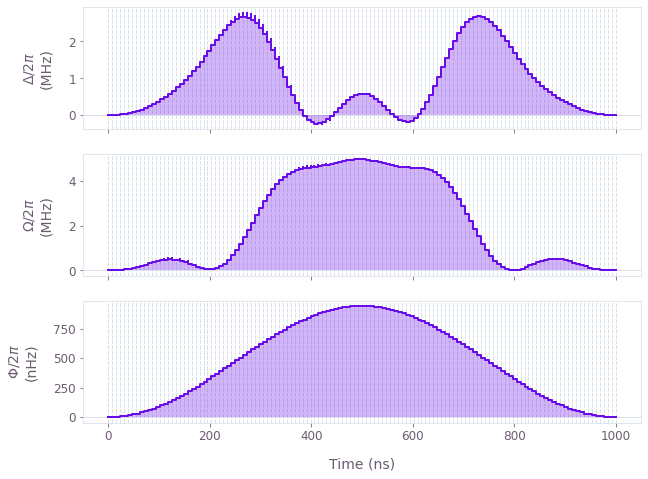

In [13]:
qv.plot_controls(controls_for_plots(result))

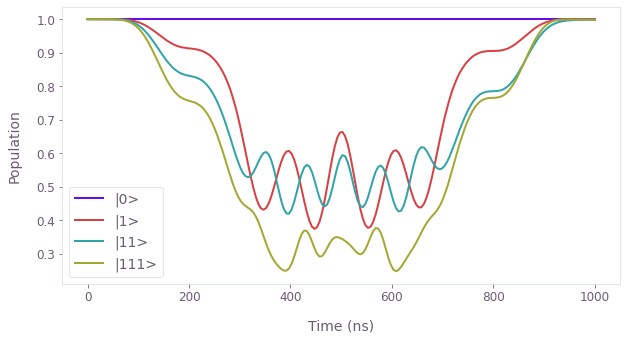

In [14]:
u = result['output']['unitary']['value']
# basis_labels = ["0", "01", "0r", "1-10", "1-r0z", "111", "r11z", "r1r", "1r1"]
psi0 = np.array([1,0,0,0,0,0,0,0,0])
out0 = np.abs(np.transpose(psi0) @ u @ psi0)**2
psi1 = np.array([0,1,0,0,0,0,0,0,0])
out1 = np.abs(np.transpose(psi1) @ u @ psi1)**2
psi11 = np.array([0,0,0,1,0,0,0,0,0])
out11 = np.abs(np.transpose(psi11) @ u @ psi11)**2
psi111 = np.array([0,0,0,0,0,1,0,0,0])
out111 = np.abs(np.transpose(psi111) @ u @ psi111)**2
plt.plot(1e9 * sample_times, out0)
plt.plot(1e9 * sample_times, out1)
plt.plot(1e9 * sample_times, out11)
plt.plot(1e9 * sample_times, out111)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend(['|0>','|1>', '|11>','|111>'])